# Differential Privacy

This notebook introduces differential privacy from the perspective of the OpenDP library.

As a simplifying assumption, assume we have a vector dataset $u$ where each record contains sensitive information about a different individual.

In [406]:
# u is a small vector dataset with contributions from:
#   [Alice, Jane, John, Jack, ...]
u = [12,    10,   8,    7,       ]

We can use differential privacy to collect measurements (statistics such as means and histograms) on this dataset, without revealing information about specific individuals.

To understand DP, it is important to first understand:
1. distance between datasets
2. distance between distributions

## Distance Between Datasets (adjacency)

An adjacent dataset is any dataset that differs from our dataset by a single individual.
Returning to our vector dataset example, let's assume our dataset $u$ has one record that contains information about a person, Alice.
Then one adjacent dataset $v$ would contain every row in $u$ except for the row with Alice's information. 

In [407]:
# v is one (of many) datasets that are adjacent to u
#   [Jane, John, Jack, ...]
v = [10,   8,    7,       ]

You can construct other datasets adjacent to $u$ by dropping a different row or adding a new row.
When one person may contribute up to $k$ rows, adjacent datasets differ by up to $k$ additions and removals. 

The number of additions/removals between any two datasets is equivalent to the cardinality of the symmetric difference between $u$ and $v$. We call this metric the symmetric distance.

$$d_{Sym}(u, v) = |u \triangle v|$$

And in code:

In [408]:
def d_Sym(u, v):
    """symmetric distance between datasets u and v"""
    return len(set(u).symmetric_difference(set(v)))

# compute the symmetric distance between our two example datasets:
d_Sym(u, v)

1

$d_{Sym}(\{12, 10, 8, 7\}, \{10, 8, 7\}) = |\{12, 10, 8, 7\} \triangle \{10, 8, 7\}| = |\{12\}| = 1$

In practice, we never directly compute these distances.
In order to apply differentially private methods, you need to establish an an upper bound on the distance between adjacent datasets.
Equivalently, this is an upper bound on the number of records any one individual may contribute.

For instance, in the vector dataset example, it was stipulated that each element contains sensitive information about a different individual. 
This statement implies that the symmetric distance between adjacent datasets, where one individual is added or removed, is at most one.
That is, for any choice of datasets $u$ and $v$ such that $u$ is adjacent to $v$ (denoted $u \sim_{Sym} v$), we have that $d_{Sym}(u, v) \leq 1$. 

Before moving on, there are some trivial generalizations. 
A dataset need not be a vector, it could be a dataframe or any other collection with a concept of records. 
There are also other dataset metrics aside from symmetric distance (used for unbounded DP), such as change-one distance (used for bounded DP). There are also variations of metrics that are sensitive to data ordering, metrics for describing distances between graphs, and more!

We should now have a sense for what an adjacent dataset means, how dataset distances work, and an intuitive understanding of the symmetric distance metric.

## Distance Between Distributions (divergence)
You can think of a measurement $M(\cdot)$ as a differentially private statistic.
Measurements are random variables (RVs), that is, they sample from noise distributions.
The outputs of a measurement are realizations of a random variable that follow a known probability distribution.
Measurements only have one parameter: a dataset (for context, a Laplace RV has parameters for shift and scale).
This section describes how to measure distance between the distributions of measurements on adjacent datasets.

A common measurement is the Laplace DP sum, which is a sample from the Laplace distribution centered at the dataset sum with a fixed noise scale.
The following plot compares the distribution of the DP sum on dataset $u$ with the distribution of the DP sum on dataset $v$, when the noise scale is fixed to `25`.

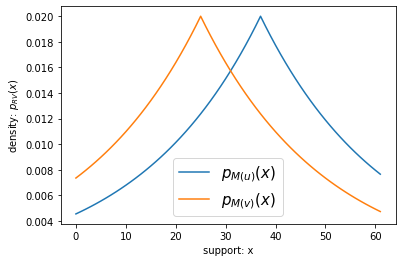

In [409]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace

scale = 25

# while in this case the support includes all reals, we only bother plotting part of it
support = np.arange(sum(v) - scale, sum(u) + scale, 1)

def plot_pdfs(u, v, support):
    u_density = laplace.pdf(support, loc=sum(u), scale=scale)
    v_density = laplace.pdf(support, loc=sum(v), scale=scale)

    plt.plot(support, u_density, label="$p_{M(u)}(x)$")
    plt.plot(support, v_density, label="$p_{M(v)}(x)$")
    plt.ylabel('density: $p_{RV}(x)$')
    plt.xlabel('support: x')
    plt.legend(prop={'size': 15})
plot_pdfs(u, v, support)


We are interested in the greatest divergence, a measure of the dissimilarity of these two distributions.
While divergences are not necessarily distances, we oftentimes informally refer to them as distances.
A common measure of divergence is the log ratio of probabilities:

$$d_{MaxDivergence}(M(u), M(v)) = max_{S \subset supp M(\cdot)} log\left(\frac{Pr[M(u) \in S]}{Pr[M(v) \in S]}\right)$$

In this equation we define the distance between the RVs $M(u)$ and $M(v)$ to be the maximum divergence among all possible subsets of the support.
The support is the set of all realizations (outcomes) of the random variable that have nonzero probability.

For our DP sum with laplacian noise example, the support of $M(\cdot)$ is the set of all real numbers, $\mathbb{R}$.
In the plot below, I illustrate this equation for one randomly chosen subset $S$ of the support:

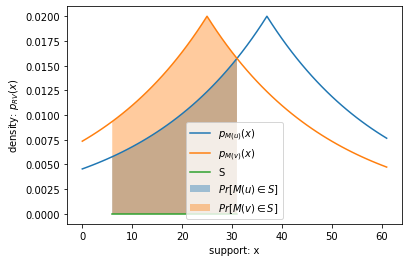

In [410]:
def plot_S(u, v, S):
    """draw the probability regions spanned by S"""
    plt.fill_between(S, laplace.pdf(S, loc=sum(u), scale=scale), label="$Pr[M(u) \in S]$", alpha=.4)
    plt.fill_between(S, laplace.pdf(S, loc=sum(v), scale=scale), label="$Pr[M(v) \in S]$", alpha=.4)
    plt.plot([np.min(S), np.max(S)], [0, 0], label="S")
    plt.legend()

# re-run this notebook to see different choices of S
S = np.arange(*sorted(np.random.choice(support, size=2, replace=False)))

plot_pdfs(u, v, support)
plot_S(u, v, S)

The area of the blue region is the probability that $M(u)$ is in $S$... and similarly the orange region for $v$.

In [411]:
def divergence_over_S(u, v):
    """prints the Divergence(M(u), M(v)) over some region S, assuming M(x) = Laplace(sum(x), scale)"""
    laplace_u = laplace(loc=sum(u), scale=scale)
    laplace_v = laplace(loc=sum(v), scale=scale)

    # integrate over both regions
    pr_Mu_in_S = laplace_u.cdf(upper) - laplace_u.cdf(lower) # blue
    pr_Mv_in_S = laplace_v.cdf(upper) - laplace_v.cdf(lower) # orange

    print("area of blue region:  ", pr_Mu_in_S)
    print("area of orange region:", pr_Mv_in_S)
    print("divergence for this S:", np.abs(np.log(pr_Mu_in_S / pr_Mv_in_S)))
divergence_over_S(u, v)

area of blue region:   0.03898172996291349
area of orange region: 0.02412124708492258
divergence for this S: 0.48000000000000403


This shows the divergence between $M(u)$ and $M(v)$ for one choice of S, but keep in mind that $d_{MaxDivergence}(M(u), M(v))$ is the greatest divergence over any choice of $S$.
Intuitively, the divergence between $M(u)$ and $M(v)$ for the same $S$ increases if Alice made a greater contribution to the statistic:

area of blue region:   0.004869995796134612
area of orange region: 0.02412124708492258
divergence for this S: 1.5999999999999979


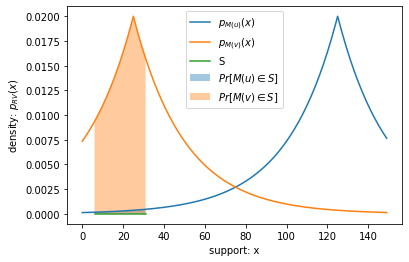

In [412]:
# hypothetical: what if Alice's contribution was 100, instead of 12?
u_prime = [100, *u[1:]]
divergence_over_S(u_prime, v)

support = np.arange(sum(v) - scale, sum(u_prime) + scale, 1)
plot_pdfs(u_prime, v, support)
plot_S(u_prime, v, S)

As we can see, when the divergence between probability distributions is greater, we can more confidently distinguish which distribution a sample came from. 
This is why the statistical divergence can be used as a meaningful measure of privacy.

In practice, it isn't feasible to compute the divergence for all possible choices of $S$. 
Fortunately, we won't need to directly compute this anyways.

## Definition of Privacy
Now that we have an understanding of distances between datasets, and distances between distributions, we can now define the privacy of a measurement, $M(\cdot)$:

> $M(\cdot)$ is $\epsilon$-differentially private if, for any choice of datasets $u$ and $v$ such that $d_{Sym}(u, v) \leq k$, we have that $d_{MaxDivergence}(M(u), M(v)) \leq \epsilon$.

In this definition, we relate a dataset distance $k$ to another distance $\epsilon$.
This $\epsilon$ is more general than the max divergence we computed in the previous section because it is the greatest divergence over all possible choices of $S$, _and over all possible pairs of adjacent datasets_ $u$ and $v$.

This has a very practical interpretation: Lets say I have a dataset $x$ for which an individual user can contribute at most $k$ rows, and a statistic $M(\cdot)$ that is $\epsilon$-DP when user contribution is at most $k$.
By the DP guarantee, it is proven that the influence of any one individual on the data release induces a divergence no greater than $\epsilon$. Thus, assuming a reasonably small choice of $\epsilon$, the individual's participation in the statistical release is private, because their influence on the data release is at most $\epsilon$-distinguishable.

If you have some background in differential privacy you may be more familiar with a definition of privacy worded like this:

> $M(\cdot)$ is $\epsilon$-differentially private if, for any choice of adjacent datasets $u$ and $v$, we have that
$Pr[M(u) \in S] \leq e^\epsilon Pr[M(v) \in S]$.

This is mostly equivalent, because of the way we've defined $d_{MaxDivergence}(M(u), M(v))$ in the previous section.
However, this formulation of the definition is ambiguous about what makes a dataset adjacent. To obtain well-defined privacy guarantees, it is important to specify the dataset metric and dataset distance.

We further generalize the definition of privacy:

> $M(\cdot)$ is $d_{out}$-differentially private with respect to input metric $MI$ and output measure $MO$ if, for any choice of datasets $u$ and $v$ such that $d_{MI}(u, v) \leq d_{in}$, we have that $d_{MO}(M(u), M(v)) \leq d_{out}$.

The first definition can be reclaimed by letting $MI$ be `SymmetricDistance` and $MO$ be `MaxDivergence`. 
$MO$ can be set to other measures of divergence to represent approximate ($\epsilon, \delta$)-differential privacy, or zero-concentrated $\rho$-differential privacy.
Similarly, our choice of `SymmetricDistance` represents unbounded DP, but we can represent bounded DP by letting $MI$ be `ChangeOneDistance`.

## Distance Between Aggregates (sensitivity)
The _sensitivity_ is the greatest amount an aggregate can change when computed on an adjacent dataset.
Aggregators are deterministic statistics (like the sum or histogram functions), and their exact outputs are aggregates.
More generally, a transformation $T(\cdot)$ is a deterministic function from a dataset to a dataset.
Aggregators are a kind of transformation, and aggregates are a kind of dataset.

One example of a sensitivity metric is the `AbsoluteDistance`, which is used to measure the distance between scalar aggregates. 
$$d_{Abs}(a, b) = |a - b|$$


In [413]:
def d_Abs(a, b):
    """computes the absolute distance between a and b"""
    return abs(a - b)

Lets use the absolute distance metric to express the sensitivity of the sum aggregator.
In our vector dataset example, we know each individual can contribute at most one record.
Since this record is unbounded, it can perturb the sum an arbitrarily large amount towards positive or negative infinity.
This is unfortunate, because it implies that the divergence is also infinite!

In order to attain a finite sensitivity, it is customary to clamp— that is, to replace any value less than a lower bound with the lower bound, and any value greater than an upper bound with the upper bound. If the transformation clamps the data to the interval $[L, U]$, and we know each individual contributes at most $d_{in}$ records, then the clamped sum sensitivity ($d_{out}$) is
$$max_{u \sim_{Sym} v} |clamped\_sum(u) - clamped\_sum(v)| = d_{in} \cdot max(|L|, U)$$

Returning to our vector dataset example, if we clamp the data between $[0, 12]$, then the sensitivity is $1 \cdot max(|0|, 12) = 12$. For any conceivable dataset $u$, adding or removing any individual (to get some dataset $v$) can change the sum by at most $12$.

In [414]:
def clamped_sum(x):
    """A function that computes the sum, where each element is clamped within [0, 12]"""
    return sum(np.clip(x, 0, 12))

Our current choice of $u$ and $v$ is an example that maximizes the absolute distance:

In [415]:
d_Abs(clamped_sum(u), clamped_sum(v))

12

You can even use the `SymmetricDistance` as the input metric $MI$ of a measurement $M(\cdot)$ (see the definition of privacy).
Lets define a new function $laplace\_noise$ to illustrate this:

In [416]:
def laplace_noise(x):
    """a naive function that adds an approximation to laplace noise"""
    return np.random.laplace(loc=x, scale=scale)

We could let $MI$ be `AbsoluteDistance` and $MO$ be `MaxDivergence`.
It can be shown that for any choice of $u$ and $v$ that differ by no more than $d_{in}$, and $d_{out} = d_{in} / scale$, then:
$$d_{MaxDivergence}(u, v) \geq d_{out}$$
Therefore, if the data types in this function had infinite precision, $laplace\_noise$ would be a measurement.
Other common metrics to express sensitivities are `L1Distance` and `L2Distance`.

## Definition of Stability
Similar to how we defined the privacy of a measurement $M(\cdot)$, we can also define the stability of a transformation, $T(\cdot)$:

> $T(\cdot)$ is $d_{out}$-stable with respect to input metric $MI$ and output metric $MO$ if, for any choice of datasets $u$ and $v$ such that $d_{MI}(u, v) \leq d_{in}$, we have that $d_{MO}(M(u), M(v)) \leq d_{out}$.

An example is the $clamped\_sum$ function from the previous section.
If the data types in the $clamped\_sum$ had infinite precision, it would be a stable transformation where $MI$ is `SymmetricDistance` and $MO$ is `AbsoluteDistance`.
We've previously shown that when $d_{in} = 1$, the sensitivity $d_{out} = 12$.

This stability guarantee does not carry privacy implications, but it lets us construct building blocks that can be chained together.
If the output metric $MO$ and output domain $DO$ of a transformation $T(\cdot)$ conform with the input metric $MI$ and input domain $DI$ of a measurement $M(\cdot)$, then it is valid to construct a new measurement $M2(\cdot) = M(T(\cdot))$.
We can similarly construct a new transformation $T(\cdot) = T2(T1(\cdot))$ by chaining.
Notice that the output domain and metric of the $clamped\_sum$ transformation conform with the input metric and domain of the $laplace\_noise$ measurement, so we can chain these together:

In [417]:
def laplace_sum(x):
    """a naive function that computes the noisy clamped sum"""
    return laplace_noise(clamped_sum(x))

Since this function was constructed by chaining a stable transformation and private measurement, it is trivial to prove that it is a private measurement (if the data types had infinite precision).
Its $MI$ is `SymmetricDistance`, and $MO$ is `MaxDivergence`, and when the dataset distance $d_{in} = 1$, we have that $\epsilon = d_{out} = 1$.

A crucial takeaway from this notebook is a high-level understanding that _differential privacy is a system to relate distances_ ($d_{in}$ and $d_{out}$).
If you can establish a bound on the distance to adjacent datasets $d_{in}$ (in terms of some metric $MI$) then you can work out the stability or privacy properties $d_{out}$ (in terms of some metric or measure $MO$) of computations made on your data.
A convenient way to express this is, if the computation is stable or private for some pair $(d_{in}, d_{out})$, then the computation is $(d_{in}, d_{out})$-close.

Unfortunately, the transformation and measurement examples in this notebook are only $(d_{in}, d_{out})$-close if we assume the data types have infinite precision— and they don't!
Building transformations or measurements that have proven stability or privacy properties is nontrivial, especially if you account for finite precision data types.
This is the purpose of the OpenDP library, which we'll cover in more detail in the next notebook.

### Addendum: Computing the `MaxDivergence`
In the "Distance Between Distributions" section, we compute a divergence for some randomly chosen subset $S$ of the support:

In [418]:
divergence_over_S(u, v)

area of blue region:   0.03898172996291349
area of orange region: 0.02412124708492258
divergence for this S: 0.48000000000000403


Save for floating-point artifacts in this computation, we would expect that this divergence is never greater than the $\epsilon$ of the $laplace\_sum$, since $\epsilon$ is the max divergence!

Lets redefine the $laplace\_noise$ function using the OpenDP library:

In [419]:
from opendp.mod import enable_features
enable_features("floating-point", "contrib")

from opendp.measurements import make_base_laplace
laplace_noise = make_base_laplace(float(scale))

Both measurements have an `AbsoluteDistance` input metric. 
We now ask the OpenDP library a hypothetical question:
> If a neighboring dataset differs by at most $d_{in} = 12$ (the distance between $sum(u)$ and $sum(v)$), then what would the maximum divergence be?

In [420]:

laplace_noise.map(d_in=12.)

0.48000000000000004

The OpenDP library solves for $\epsilon$, the smallest upper bound on divergences!
